In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [2]:
X_train=X_train/255
X_test=X_test/255

5

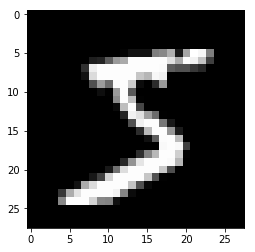

In [3]:
plt.imshow(X_train[0], cmap='gray')
y_train[0]

In [4]:
class VAE():
    def __init__(self, n_latent=2):
        self.n_latent = n_latent
        self._build_encoder()
        self._build_decoder()
        
        epsilon = 1e-10
        self.reconstruction_loss = -tf.reduce_sum(self.x_flat*tf.log(self.x_hat+epsilon)+(1-self.x_flat)*tf.log(1-self.x_hat+epsilon),axis=1)
        self.latent_loss = -0.5*tf.reduce_sum(1+self.z_logvar-tf.square(self.z_mu)- tf.exp(self.z_logvar), axis=1)
        self.loss = tf.reduce_mean(self.reconstruction_loss+self.latent_loss)
        self.train_op = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(self.loss)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        self.saver = tf.train.Saver()
        
    def _build_encoder(self):
        self.x = tf.placeholder(dtype=tf.float32,shape=[None, 28, 28, 1])
        self.x_flat = tf.contrib.layers.flatten(self.x)
        net = tf.layers.conv2d(self.x, filters=32, kernel_size=[5, 5], padding='same', activation=tf.nn.relu)
        net = tf.layers.max_pooling2d(net, pool_size=[2, 2], strides=[2, 2])
        net = tf.layers.conv2d(self.x, filters=64, kernel_size=[5, 5], padding='same', activation=tf.nn.relu)
        net = tf.layers.max_pooling2d(net, pool_size=[2, 2], strides=[2, 2])
        net = tf.contrib.layers.flatten(net)
        net = tf.layers.dense(net, 100, activation=tf.nn.relu)
        
        self.z_mu = tf.layers.dense(net, self.n_latent)
        self.z_logvar = tf.layers.dense(net, self.n_latent)
        eps = tf.random_normal(shape=tf.shape(self.z_logvar),mean=0,stddev=1,dtype=tf.float32)
        self.z = self.z_mu + tf.exp(0.5*self.z_logvar)*eps
        
    def _build_decoder(self):
        net = tf.layers.dense(self.z, 100, activation=tf.nn.relu)
        net = tf.layers.dense(net, 64*7*7, activation=tf.nn.relu)
        net = tf.reshape(net, [-1, 7, 7, 64])
        net = tf.layers.conv2d_transpose(net, filters=32, kernel_size=[5, 5], strides=[2, 2], padding='same', activation=tf.nn.relu)
        net = tf.layers.conv2d_transpose(net, filters=1, kernel_size=[5, 5], strides=[2, 2], padding='same', activation=tf.nn.sigmoid)
        self.x_hat = tf.contrib.layers.flatten(net)
        
    def run_single_step(self,x):
        _, loss = self.sess.run([self.train_op,self.loss], feed_dict={self.x: x})
        return loss
        
    #reconstruction
    #x->x_hat
    def reconstruction(self,x):
        return self.sess.run(self.x_hat, feed_dict={self.x: x})
        
    #generation
    #z->x_hat
    def generate(self,z):
        return self.sess.run(self.x_hat,feed_dict={self.z: z})

    #transformation of features
    #x->z
    def transformer(self,x):
        return self.sess.run(self.z,feed_dict={self.x: x})

In [5]:
vae = VAE(5)

In [6]:
X_train = X_train[...,np.newaxis]

In [7]:
epoch = 10
batch_size = 32

for ep in range(epoch):
    for i in range(X_train.shape[0] // batch_size):
        loss = vae.run_single_step(X_train[i*batch_size:(i+1)*batch_size])
    print('[Epoch {}] Loss: {}'.format(ep+1,loss))

[Epoch 0] Loss: 150.1802215576172
[Epoch 1] Loss: 139.01173400878906
[Epoch 2] Loss: 136.48599243164062
[Epoch 3] Loss: 131.1194305419922
[Epoch 4] Loss: 129.4243621826172
[Epoch 5] Loss: 126.3036117553711
[Epoch 6] Loss: 125.36540222167969
[Epoch 7] Loss: 123.800048828125
[Epoch 8] Loss: 122.91801452636719
[Epoch 9] Loss: 123.82699584960938


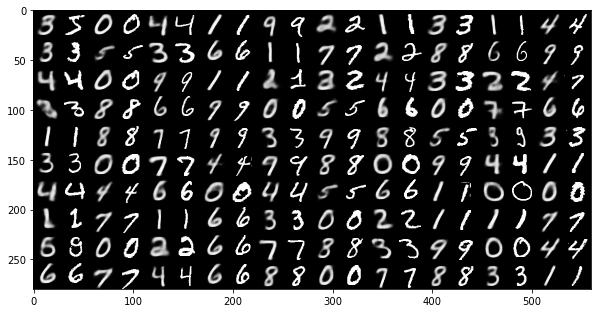

In [8]:
h = w = 28
#reconstruction
#z = np.random.normal(size=[model.batch_size,model.n_z])
batch = X_train[:100]
x_reconstructed = vae.reconstruction(batch)
#x_generated = model.generate(z)
n=10
I_reconstructed = np.empty((h*n,2*w*n))

for i in range(n):
    for j in range(n):
        x = np.concatenate((x_reconstructed[i*n+j,:].reshape(h,w),batch[i*n+j,:].reshape(h,w)),axis=1)
        I_reconstructed[i*h:(i+1)*h,j*2*w:(j+1)*2*w] = x
plt.figure(figsize = (10,20))
plt.imshow(I_reconstructed,cmap='gray')

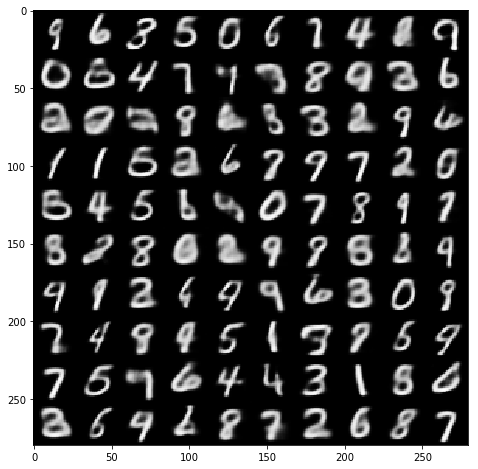

In [9]:
# Test the trained model: generation
# Sample noise vectors from N(0, 1)
z = np.random.normal(size=[100, vae.n_latent])
x_generated = vae.generate(z)

n = np.sqrt(100).astype(np.int32)
I_generated = np.empty((h*n, w*n))
for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(28, 28)

plt.figure(figsize=(8, 8))
plt.imshow(I_generated, cmap='gray')

In [10]:
model_2d = VAE(2)

In [11]:
epoch = 10
batch_size = 32

for ep in range(epoch):
    for i in range(X_train.shape[0] // batch_size):
        loss = model_2d.run_single_step(X_train[i*batch_size:(i+1)*batch_size])
    print('[Epoch {}] Loss: {}'.format(ep+1,loss))

[Epoch 0] Loss: 196.1122589111328
[Epoch 1] Loss: 175.95082092285156
[Epoch 2] Loss: 170.86891174316406
[Epoch 3] Loss: 165.2093505859375
[Epoch 4] Loss: 165.46678161621094
[Epoch 5] Loss: 162.2286376953125
[Epoch 6] Loss: 160.44525146484375
[Epoch 7] Loss: 160.72573852539062
[Epoch 8] Loss: 159.27273559570312
[Epoch 9] Loss: 158.30130004882812


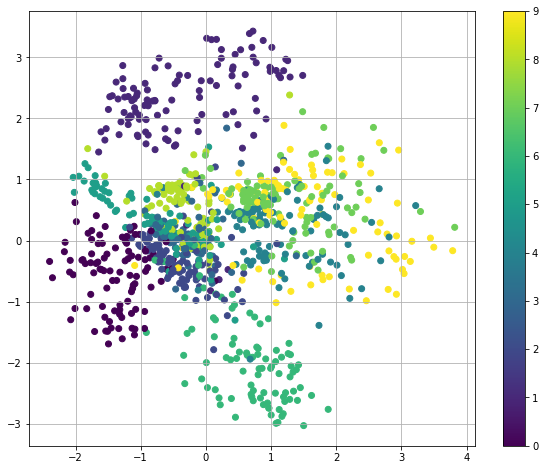

In [12]:
# Test the trained model: transformation

z = model_2d.transformer(X_train[:1000])
plt.figure(figsize=(10, 8)) 
plt.scatter(z[:, 0], z[:, 1], c=y_train[:1000])
plt.colorbar()
plt.grid()
plt.show()

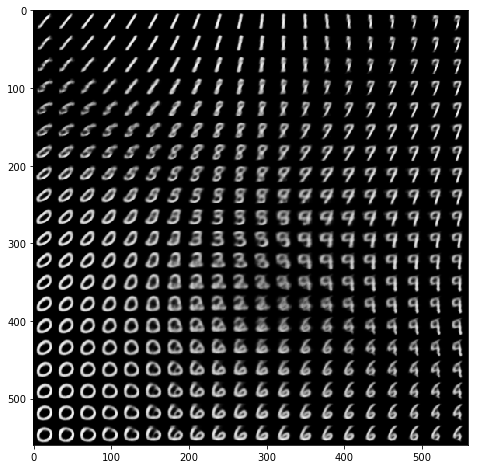

In [13]:
# Test the trained model: transformation
n = 20
x = np.linspace(-2, 2, n)
y = np.linspace(-2, 2, n)

I_latent = np.empty((h*n, w*n))
for i, yi in enumerate(x):
    for j, xi in enumerate(y):
        z = np.array([[xi, yi]])
        x_hat = model_2d.generate(z)
        I_latent[(n-i-1)*28:(n-i)*28, j*28:(j+1)*28] = x_hat[0].reshape(28, 28)

plt.figure(figsize=(8, 8))        
plt.imshow(I_latent, cmap="gray")